# Analysis of power outages 

**Name(s)**: Michael Sagar Vasandani and Omar Ali

**Website Link**: (your website link)

Necessary imports

In [133]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'
import folium
import geopandas as gpd
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim  # Import Nominatim from geopy
from folium.plugins import TimestampedGeoJson
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor




## Step 1: Introduction

Question: Is the average amount of outages greater in 2022 than in other years

## Step 2: Data Cleaning and Exploratory Data Analysis

In [134]:
data = pd.read_excel('data/outage.xlsx', skiprows=5)
data = data.drop(columns = 'variables')
data = data[1:]
data.set_index('OBS', inplace=True)
columns_to_keep = [
    'YEAR',
    'MONTH',
    'U.S._STATE',
    'NERC.REGION',
    'ANOMALY.LEVEL',
    'CLIMATE.CATEGORY',
    'OUTAGE.START.DATE',
    'OUTAGE.START.TIME',
    'OUTAGE.RESTORATION.DATE',
    'OUTAGE.RESTORATION.TIME',
    'CAUSE.CATEGORY',
    'CAUSE.CATEGORY.DETAIL',
    'OUTAGE.DURATION',
    'DEMAND.LOSS.MW',
    'CUSTOMERS.AFFECTED',
    'RES.CUSTOMERS',
    'COM.CUSTOMERS',
    'IND.CUSTOMERS',
    'TOTAL.CUSTOMERS'
]

In [135]:
data = data[columns_to_keep]

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 1.0 to 1534.0
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   YEAR                     1534 non-null   float64
 1   MONTH                    1525 non-null   float64
 2   U.S._STATE               1534 non-null   object 
 3   NERC.REGION              1534 non-null   object 
 4   ANOMALY.LEVEL            1525 non-null   object 
 5   CLIMATE.CATEGORY         1525 non-null   object 
 6   OUTAGE.START.DATE        1525 non-null   object 
 7   OUTAGE.START.TIME        1525 non-null   object 
 8   OUTAGE.RESTORATION.DATE  1476 non-null   object 
 9   OUTAGE.RESTORATION.TIME  1476 non-null   object 
 10  CAUSE.CATEGORY           1534 non-null   object 
 11  CAUSE.CATEGORY.DETAIL    1063 non-null   object 
 12  OUTAGE.DURATION          1476 non-null   object 
 13  DEMAND.LOSS.MW           829 non-null    object 
 14  CUSTOMERS.AFFECTED       

Combining Outage.start.date and outage.start.time, same thing with outage.restoration

In [137]:
# Combine 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME' into a single 'OUTAGE.START' column
data['OUTAGE.START'] = pd.to_datetime(data['OUTAGE.START.DATE']) + pd.to_timedelta(data['OUTAGE.START.TIME'].astype(str))

# Combine 'OUTAGE.RESTORATION.DATE' and 'OUTAGE.RESTORATION.TIME' into a single 'OUTAGE.RESTORATION' column
data['OUTAGE.RESTORATION'] = pd.to_datetime(data['OUTAGE.RESTORATION.DATE']) + pd.to_timedelta(data['OUTAGE.RESTORATION.TIME'].astype(str))

# Display the first few rows of the relevant columns to verify the results
data[['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.START', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'OUTAGE.RESTORATION']].head()

,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.START,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,OUTAGE.RESTORATION
OBS,,,,,,
1.0,2011-07-01 00:00:00,17:00:00,2011-07-01 17:00:00,2011-07-03 00:00:00,20:00:00,2011-07-03 20:00:00
2.0,2014-05-11 00:00:00,18:38:00,2014-05-11 18:38:00,2014-05-11 00:00:00,18:39:00,2014-05-11 18:39:00
3.0,2010-10-26 00:00:00,20:00:00,2010-10-26 20:00:00,2010-10-28 00:00:00,22:00:00,2010-10-28 22:00:00
4.0,2012-06-19 00:00:00,04:30:00,2012-06-19 04:30:00,2012-06-20 00:00:00,23:00:00,2012-06-20 23:00:00
5.0,2015-07-18 00:00:00,02:00:00,2015-07-18 02:00:00,2015-07-19 00:00:00,07:00:00,2015-07-19 07:00:00


## univariate analysis

In [205]:

# Ensure the YEAR column is in the dataset and of numeric type
data['YEAR'] = pd.to_numeric(data['YEAR'], errors='coerce')

# Create the distribution plot for the YEAR column
fig = px.histogram(data, x='YEAR', nbins=len(data['YEAR'].unique()), 
                   title='Distribution of Years in Dataset', 
                   labels={'YEAR': 'Year'}, 
                   color_discrete_sequence=['blue'])

# Update layout for better appearance
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Count",
    bargap=0.1
)

# Show the figure
fig.show()
fig.write_html("scatter_plot.html")


This histogram shows the distribution of records across different years in your dataset. Here’s what it reveals:

Uneven Distribution:

Some years, like 2010, have a significantly higher count of records compared to others. This could indicate an unusual event or increased reporting activity during that year.
There are fewer records in earlier years (e.g., 2000-2004) and later years (e.g., 2016), possibly due to incomplete data collection in those periods.
Potential Data Bias:

The concentration of records in certain years might skew your model if the events in those years are not representative of the overall data distribution.
Dataset Coverage:

The dataset spans a range of years from 2000 to 2016, but the counts are not evenly distributed. This could impact how well the model generalizes if years with low representation are critical.
This distribution suggests that data from some years dominate the dataset, and you should consider whether this distribution aligns with your modeling goals. For instance, if you're using temporal features like YEAR, you might need to account for the imbalance to prevent the model from overfitting to dominant years.

In [206]:
# URL to a GeoJSON file for U.S. state boundaries
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'

# Create a map centered on the U.S.
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Calculate the number of outages for each state
state_outage_count = data.groupby('U.S._STATE').size().reset_index(name='OUTAGE_COUNT')

# Add a Choropleth layer to visualize the number of outages by state
folium.Choropleth(
    geo_data=url,
    data=state_outage_count,
    columns=['U.S._STATE', 'OUTAGE_COUNT'],
    key_on='feature.properties.name',  # Matches GeoJSON 'name' property with 'U.S._STATE'
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Outages by State'
).add_to(m)

m
m.save("univariate2.html")


This map represents the **number of power outages by state in the United States**. The intensity of the color in each state reflects the total number of outages recorded in the dataset for that state:

- **Darker shades (e.g., red or orange)** indicate states with a higher number of recorded outages.
- **Lighter shades (e.g., yellow)** represent states with fewer outages.

### Key Insights:
1. **States with High Outages**:
   - States like **California** and **Texas** appear darker, suggesting they experience a significant number of power outages compared to other states. This could be due to factors such as population density, infrastructure stress, or exposure to natural disasters.

2. **States with Low Outages**:
   - States with lighter colors, such as **Midwestern states or less populated regions**, indicate fewer outages.

3. **Geographic Patterns**:
   - Outages may be concentrated in regions with specific vulnerabilities, such as coastal areas prone to severe weather or densely populated regions with high energy demands.

This visualization can help identify trends in power outages and focus efforts on improving infrastructure or addressing vulnerabilities in high-outage states.

### Bivariate analysis


In [207]:
# Box Plot: YEAR vs TOTAL.CUSTOMERS
box_plot = px.box(
    data,
    x="YEAR",
    y="TOTAL.CUSTOMERS",
    title="Box Plot: Yearly Distribution of Customers Affected by Outages",
    labels={"YEAR": "Year", "CUSTOMERS.AFFECTED": "customers affected"},
    color="YEAR",  # Differentiate by year
    points="all"  # Show all data points
)
box_plot.show()
box_plot.write_html("bivariate1.html")

This box plot displays the yearly distribution of **total customers affected by outages**. Here's what the graph shows:

1. **Variability Across Years**:
   - Each box represents the spread of the total number of customers affected in a given year. The **box length (interquartile range, or IQR)** highlights the middle 50% of values, while the **whiskers** extend to the minimum and maximum values within 1.5 times the IQR.

2. **Median Impact**:
   - The line within each box shows the median number of affected customers for that year. It provides a central value for comparison across years.

3. **Outliers**:
   - The dots beyond the whiskers represent **outliers**, indicating extreme outage events that affected significantly more customers than typical outages that year.

4. **Trends Across Years**:
   - Some years, such as **2004**, **2012**, and **2014**, exhibit larger IQRs, suggesting greater variability in the number of customers affected by outages. This could point to years with more severe or widespread outages.
   - In contrast, years like **2000**, **2010**, and **2016** show more compact distributions, implying less variability.

5. **High-Impact Years**:
   - Years like **2002**, **2014**, and **2008** show outliers affecting a significant number of customers, indicating major outage events.

**Significance:**
This plot provides insights into how the impact of outages varies annually. It highlights years with greater variability or extreme events, allowing for further investigation into causes such as weather patterns, infrastructure failures, or other contributing factors during those years.

In [208]:

# Group data by YEAR and CAUSE.CATEGORY and calculate the total number of customers for each category per year
cause_year_distribution = data.groupby(['YEAR', 'CAUSE.CATEGORY'])['TOTAL.CUSTOMERS'].sum().reset_index()

# Create a stacked bar chart
fig = px.bar(
    cause_year_distribution,
    x='YEAR',
    y='TOTAL.CUSTOMERS',
    color='CAUSE.CATEGORY',
    title='Distribution of Cause Categories by Year',
    labels={'YEAR': 'Year', 'TOTAL.CUSTOMERS': 'Total Customers', 'CAUSE.CATEGORY': 'Cause Category'},
    text_auto=True
)

# Show the chart
fig.show()
fig.write_html("bivariate2.html")

This graph shows the distribution of different cause categories for power outages by year. Key insights from the graph include:

1. **Yearly Trends**: 
   - Certain years have significantly higher total customer impacts, such as 2008, 2010, and 2012, suggesting that major events occurred during these years.
   - Other years, like 2000 and 2002, show relatively lower impacts, possibly indicating fewer large-scale outages.

2. **Dominant Cause Categories**:
   - **Severe Weather** (green) appears as a major cause category across multiple years, especially in years with high total impacts like 2008 and 2012. This emphasizes the significant role of weather-related events in power outages.
   - **Intentional Attacks** (red) and **Fuel Supply Emergencies** (pink) contribute less to the overall total but appear in specific years, indicating localized or rare events.

3. **Variability in Categories**:
   - Some categories like **System Operability Disruption** and **Public Appeal** show sporadic impacts rather than consistent trends across years.
   - Categories like **Equipment Failure** show smaller and steadier contributions, suggesting a constant but less dramatic role.

4. **Event Peaks**:
   - Spikes in particular years can indicate events like hurricanes, storms, or infrastructure failures that disproportionately impacted a large number of customers.

This graph highlights how power outage causes vary over time and helps identify which categories contribute most to customer disruptions in specific years.

### Interesting Aggregates

In [142]:
# Assuming `data` is your DataFrame with the relevant columns
pivot_table = data.pivot_table(
    index='YEAR',            # Group by YEAR
    columns='CAUSE.CATEGORY',  # Columns for each Cause Category
    values='CUSTOMERS.AFFECTED',  # Aggregate based on CUSTOMERS.AFFECTED
    aggfunc='sum',            # Aggregation function (sum in this case)
    fill_value=0              # Replace NaN with 0
)
display(pivot_table)

CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
YEAR,,,,,,,
2000.0,218273.0,0.0,0.0,0.0,0.0,1420308.0,2632000.0
2001.0,0.0,0.0,0.0,0.0,0.0,36073.0,1395338.0
2002.0,0.0,0.0,0.0,0.0,0.0,6102586.0,280000.0
2003.0,325531.0,0.0,0.0,0.0,0.0,5399727.0,6737850.0
2004.0,354124.0,0.0,0.0,0.0,55800.0,13018174.0,164458.0
2005.0,951500.0,0.0,0.0,0.0,0.0,11929634.0,670950.0
2006.0,0.0,0.0,0.0,0.0,8000.0,9166910.0,977182.0
2007.0,0.0,0.0,0.0,9600.0,0.0,5735133.0,228700.0
2008.0,616980.0,0.0,0.0,40046.0,8000.0,18100814.0,1199086.0


This pivot table aggregates the total number of customers affected by power outages in each year for various cause categories. Here are the insights this table provides:

**1. Dominant Cause Categories**
   - The largest values in each row indicate which cause category affected the most customers in a given year. For example:
     - **Severe Weather** appears to have the highest impact in most years, highlighting it as a major contributor to power outages.

**2. Trends Across Years**
   - The table shows fluctuations in the number of customers affected annually for each cause category. For example:
     - **Severe Weather** consistently affects customers but shows spikes in certain years (e.g., 2008 and 2012).
     - Categories like **Fuel Supply Emergency** and **Intentional Attack** rarely have any impact, indicating they are less frequent causes.

**3. Emerging Patterns**
   - For certain categories (e.g., **System Operability Disruption**), there are significant variations in impact across years, which may indicate the influence of specific major incidents during those times.
   - Categories like **Public Appeal** and **Islanding** consistently show low values, indicating minimal overall customer impact.

**4. High-Impact Years**
   - Specific years (e.g., **2008**, **2012**) show a higher total number of customers affected across all categories. These could correspond to years with severe events like hurricanes, ice storms, or heatwaves.

**5. Gaps or Missing Data**
   - Several rows have `0` values for many cause categories, which might reflect either missing data or years where those causes were not a factor.

**Applications of Insights**
   - **Resource Allocation:** Knowing that severe weather dominates, resources can be directed toward weatherproofing infrastructure.
   - **Policy Planning:** Years with spikes in certain causes can guide mitigation strategies for future preparedness.
   - **Further Analysis:** The trends could be correlated with external factors such as climate anomalies, policy changes, or regional infrastructure investments.

This table is highly effective for identifying patterns and prioritizing focus areas in mitigating outage impacts.

## Step 3: Assessment of Missingness

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 1.0 to 1534.0
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   YEAR                     1534 non-null   float64       
 1   MONTH                    1525 non-null   float64       
 2   U.S._STATE               1534 non-null   object        
 3   NERC.REGION              1534 non-null   object        
 4   ANOMALY.LEVEL            1525 non-null   object        
 5   CLIMATE.CATEGORY         1525 non-null   object        
 6   OUTAGE.START.DATE        1525 non-null   object        
 7   OUTAGE.START.TIME        1525 non-null   object        
 8   OUTAGE.RESTORATION.DATE  1476 non-null   object        
 9   OUTAGE.RESTORATION.TIME  1476 non-null   object        
 10  CAUSE.CATEGORY           1534 non-null   object        
 11  CAUSE.CATEGORY.DETAIL    1063 non-null   object        
 12  OUTAGE.DURATION          1476 non-n

## NMAR

NMAR: DEMAND.LOSS.MW: This column indicates the megawatt demand loss during an outage. The missingness could be NMAR if the probability of missing data depends on the magnitude of the demand loss itself. For example, minor outages might not have detailed demand loss recorded, leading to missing values. Alternatively, in significant outages, the complexity of measuring demand loss might result in missing data.

### Checking if missing values in CUSTOMER.AFFECTED column is dependent on another column or not

In [209]:
def mcarmar(data, missing_column='DEMAND.LOSS.MW', column='NERC.REGION', n_repetitions=500):
    """
    Test if missingness in a specified column is MCAR or MAR with respect to another column in the dataset.
    
    Parameters:
    - data: DataFrame containing the data to be tested.
    - missing_column: Name of the column to check for missingness.
    - column: Name of the column to group by.
    - n_repetitions: Number of random permutations for the TVD calculation.
    
    Returns:
    - A dictionary containing observed TVD, p-value, and the conclusion (MCAR or MAR).
    """
    # Step 1: Create the binary "missingness" column for the specified missing column
    demand_missing = (
        data
        .assign(missing_indicator=data[missing_column].isna())
        .pivot_table(index=column, columns='missing_indicator', aggfunc='size')
    )

    # Ensure columns are named clearly
    demand_missing.columns = ['missing = False', 'missing = True']
    demand_missing = demand_missing / demand_missing.sum()

    # Visualize the proportion of missing data for each category of the grouping column
    display(demand_missing.plot(kind='barh', title=f'{column} by Missingness of {missing_column}', barmode='group'))

    # Step 2: Calculate observed TVD
    observed_tvd = demand_missing.diff(axis=1).iloc[:, -1].abs().sum() / 2
    
    tvds = []
    for _ in range(n_repetitions):
        shuffled = data.copy()
        shuffled[column] = np.random.permutation(shuffled[column])
        
        pivoted = (
            shuffled
            .assign(missing_indicator=shuffled[missing_column].isna())
            .pivot_table(index=column, columns='missing_indicator', aggfunc='size')
        )
        
        # Ensure missingness indicator columns are present, even if missing in the current permutation
        pivoted = pivoted.reindex(columns=[False, True], fill_value=0)
        pivoted = pivoted / pivoted.sum()
        
        tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
        tvds.append(tvd)
    
    # Calculate p-value
    p_value = np.mean(np.array(tvds) >= observed_tvd)
    
    # Plot the empirical distribution of the TVD
    fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title=f'Empirical Distribution of the TVD for {missing_column}')
    fig.add_vline(x=observed_tvd, line_color='red', line_width=2, opacity=1)
    fig.add_annotation(
        text=f'<span style="color:red">Observed TVD = {round(observed_tvd, 4)}</span>',
        x=observed_tvd * 1.1, 
        y=0.15, 
        showarrow=False
    )
    fig.update_layout(yaxis_range=[0, 0.2])
    fig.show()
    fig.write_html(f"mar{missing_column}against{column}.html")

    # Print results
    print(f'Observed TVD: {observed_tvd:.4f}, p-value: {p_value:.4f}')
    print(f'MCAR vs MAR conclusion: {"MAR" if p_value < 0.01 else "MCAR"}')
    
    return {
        'observed_tvd': observed_tvd,
        'p_value': p_value,
        'conclusion': 'MAR' if p_value < 0.01 else 'MCAR'
    }


In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 1.0 to 1534.0
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   YEAR                     1534 non-null   float64       
 1   MONTH                    1525 non-null   float64       
 2   U.S._STATE               1534 non-null   object        
 3   NERC.REGION              1534 non-null   object        
 4   ANOMALY.LEVEL            1525 non-null   object        
 5   CLIMATE.CATEGORY         1525 non-null   object        
 6   OUTAGE.START.DATE        1525 non-null   object        
 7   OUTAGE.START.TIME        1525 non-null   object        
 8   OUTAGE.RESTORATION.DATE  1476 non-null   object        
 9   OUTAGE.RESTORATION.TIME  1476 non-null   object        
 10  CAUSE.CATEGORY           1534 non-null   object        
 11  CAUSE.CATEGORY.DETAIL    1063 non-null   object        
 12  OUTAGE.DURATION          1476 non-n

**Checking customers affected and U.S._STATE**

In [211]:
mcarmar(data, missing_column='CUSTOMERS.AFFECTED', column='U.S._STATE', n_repetitions=10000)

Observed TVD: 0.3671, p-value: 0.0000
MCAR vs MAR conclusion: MAR


{'observed_tvd': np.float64(0.36712751364022894),
 'p_value': np.float64(0.0),
 'conclusion': 'MAR'}

**Checking Customers affected and year**

In [212]:
mcarmar(data, 'DEMAND.LOSS.MW', 'MONTH', 5000 )

Observed TVD: 0.1021, p-value: 0.0172
MCAR vs MAR conclusion: MCAR


{'observed_tvd': np.float64(0.1020811913886033),
 'p_value': np.float64(0.0172),
 'conclusion': 'MCAR'}

**Imputing Customers affected depending on state**

In [148]:
def prob_impute(s):
    s = s.copy()
    num_null = s.isna().sum()
    # Check if there are any non-NaN values to sample from
    if num_null > 0:
        if len(s.dropna()) > 0:
            fill_values = np.random.choice(s.dropna(), num_null)
            s[s.isna()] = fill_values
        else:
            # Handle groups where all values are NaN
            s[s.isna()] = 0  # Or use a default value like overall mean/median
    return s

data_imputed = data.copy()
data_imputed['CUSTOMERS.AFFECTED'] = (
    data_imputed
    .groupby('U.S._STATE')
    ['CUSTOMERS.AFFECTED']
    .transform(prob_impute)
)

# Check if NaNs remain
data_imputed['CUSTOMERS.AFFECTED'].info()


<class 'pandas.core.series.Series'>
Index: 1534 entries, 1.0 to 1534.0
Series name: CUSTOMERS.AFFECTED
Non-Null Count  Dtype  
--------------  -----  
1534 non-null   float64
dtypes: float64(1)
memory usage: 24.0 KB


## Step 4: Hypothesis Testing

**Null Hypothesis (H₀)**:  
The mean number of customers affected in 2011 is less than or equal to the mean for other years.  

**Alternative Hypothesis (H₁)**:  
The mean number of customers affected in 2011 is greater than the mean for other years.  

**Test**:  
Permutation test to compare if 2011 has a greater mean than other years.

In [149]:
# Step 1: Separate data for 2011 and other years
data_2011 = data_imputed[data_imputed['YEAR'] == 2011]['CUSTOMERS.AFFECTED']
data_other_years = data_imputed[data_imputed['YEAR'] != 2011]['CUSTOMERS.AFFECTED']

# Step 2: Calculate the observed difference in means
observed_diff = data_2011.mean() - data_other_years.mean()

In [157]:
n_repititions = 10000


differences = []
for _ in range(n_repititions):
    shuffeled = data_imputed.assign(shuffled_customers = np.random.permutation(data_imputed['CUSTOMERS.AFFECTED']))
    ## step 2: Compute the test statistic
    diff_2011 = shuffeled[shuffeled['YEAR'] == 2011]['shuffled_customers'].mean()
    diff_other_years = shuffeled[shuffeled['YEAR'] != 2011]['shuffled_customers'].mean()
    difference = diff_2011 - diff_other_years
    differences.append(difference)



In [151]:
p_value = np.mean(np.array(differences) >= observed_diff)

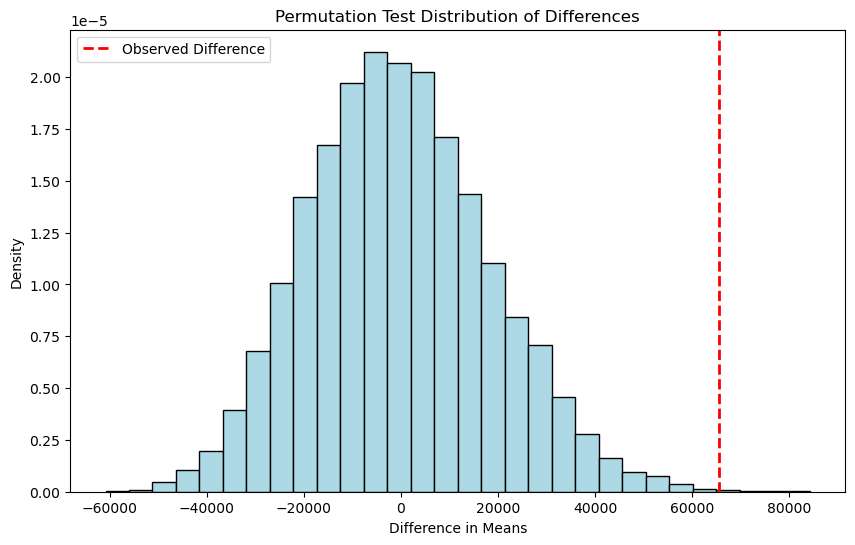

In [158]:
# Step 4: Plot the histogram of the differences
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(differences, bins=30, color='lightblue', edgecolor='black', density=True)

# Add a vertical line for the observed difference
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')

# Add labels, title, and legend
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.title('Permutation Test Distribution of Differences')
plt.legend()

# Display the plot
plt.show()

In [216]:
fig = px.histogram(pd.DataFrame(differences), x=0, nbins=50, histnorm='probability', 
                title=f'Permutation Test Distribution of Differences')
fig.add_vline(x=observed_diff, line_color='red', line_width=2, opacity=1)
fig.add_annotation(
    text=f'<span style="color:red">Observed TVD = {round(observed_diff, 4)}</span>',
    x=observed_diff * 1.1, 
    y=0.15, 
    showarrow=False
)
fig.update_layout(yaxis_range=[0, 0.2])
fig.show()
fig.write_html("hypothesispermutation.html")
    

## Step 5: Framing a Prediction Problem

### Prediction Problem
The prediction problem is to determine the **cause category** of a major power outage based on historical data. This is a **multiclass classification problem**, as there are multiple possible causes (e.g., Weather, Equipment Failure, Human Error, etc.).

---

### Response Variable
The response variable is **`CAUSE.CATEGORY`**, which categorizes the primary reason for the outage.  
**Reason for Choice:** This variable is critical for understanding and mitigating future power outages. Predicting the cause helps utility companies allocate resources, improve infrastructure, and plan for disruptions more effectively.

---

### Evaluation Metric
**Primary Metric:** **F1-Score**  
**Reason for Choice:**  
- The dataset likely has **imbalanced classes** (e.g., weather-related outages might dominate). Accuracy would not capture performance well in this case, as a model could simply predict the majority class and still achieve high accuracy.
- F1-Score balances **precision** and **recall**, ensuring the model performs well across all classes, including minority ones.
- A **weighted F1-Score** will be used to account for the class imbalances while still considering the overall performance.

---

### Type of Prediction and Justification of Features
**Type of Prediction:** Multiclass Classification  
At the time of prediction, we assume the following information is known:
- **Time-Related Features** (e.g., `YEAR`, `MONTH`, `SEASON`)—available at the start of the outage.
- **Geographic Information** (`U.S._STATE`, `NERC.REGION`)—inherent to the location of the outage.
- **Impact Features** (e.g., `TOTAL.CUSTOMERS`, `CUSTOMERS.AFFECTED`)—these are known during or immediately after the outage.
- **Anomaly Levels and Climate Categories**—typically associated with outage reports and can be available from weather systems.

Features like `OUTAGE.RESTORATION` or exact durations will **not** be used for prediction, as these are not known at the time the outage occurs.

---

### Summary
- **Problem Type:** Multiclass Classification
- **Response Variable:** `CAUSE.CATEGORY`
- **Evaluation Metric:** Weighted F1-Score (accounts for imbalanced classes)
- **Feature Constraints:** Only include data available at the time of the outage.  

Would you like help designing a pipeline to preprocess the data and build the model?

## Step 6: Baseline Model

### Logistic Regression

### **Model Description**

---

### **Prediction Problem**  
The goal is to predict the **cause of a major power outage**. This is a **multiclass classification problem** where the target variable is **`CAUSE.CATEGORY`**, which includes causes like **Weather**, **Equipment Failure**, and **Human Error**.

---

### **Response Variable**  
- **Response Variable**: `CAUSE.CATEGORY` (Multiclass Target)  
- **Why It Was Chosen**: Knowing the cause of an outage helps utility companies respond faster, allocate resources better, and prevent future outages.

---

### **Features Used**  
1. **`U.S._STATE`** (Nominal, One-Hot Encoded)  
   - **Why It Was Chosen**: Different states have different climates, weather patterns, and infrastructure, which may influence the cause of the outage.  
   - **Transformation**: One-Hot Encoded to convert categorical states into binary indicator columns.  

2. **`TOTAL.CUSTOMERS`** (Quantitative, Standardized)  
   - **Why It Was Chosen**: Larger outages may be linked to specific causes, like weather or equipment failure, while smaller outages might result from human error.  
   - **Transformation**: Standardized using `StandardScaler` to ensure consistent scaling for logistic regression.  

---

### **Pipeline Design**  
1. **Preprocessing**:  
   - **One-Hot Encode**: Converts `U.S._STATE` into binary columns.  
   - **Standardization**: Scales `TOTAL.CUSTOMERS` to have mean 0 and standard deviation 1.  

2. **Model**:  
   - **Logistic Regression** (Multinomial) to predict the cause of an outage.  
   - **Why Logistic Regression?** It’s simple, interpretable, and effective for baseline models.  

---

### **Performance Metrics**  
- **Accuracy**: Measures overall prediction correctness.  
- **F1-Score**: Used to account for class imbalance, as some causes (like Weather) may be more common than others.  

---

### **Summary**  
- **Problem**: Multiclass classification to predict the cause of a major power outage.  
- **Response Variable**: `CAUSE.CATEGORY`.  
- **Features**: `U.S._STATE` (one-hot encoded) and `TOTAL.CUSTOMERS` (standardized).  
- **Preprocessing**: One-Hot Encoding and Standardization.  
- **Model**: Multinomial Logistic Regression.  
- **Metrics**: Accuracy and Weighted F1-Score to evaluate model performance.

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [170]:
X = data_imputed[['U.S._STATE', 'TOTAL.CUSTOMERS']]
y = data_imputed['CAUSE.CATEGORY']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe_state', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE']),
        ('scaler_total_customers', StandardScaler(), ['TOTAL.CUSTOMERS'])
    ]
)

In [173]:
# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, multi_class='multinomial'))
])

# Step 5: Train the model
pipeline.fit(X_train, y_train)


/Users/michaelvasandani/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe_state',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['U.S._STATE']),
                                                 ('scaler_total_customers',
                                                  StandardScaler(),
                                                  ['TOTAL.CUSTOMERS'])])),
                ('classifier',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

In [174]:
y_pred = pipeline.predict(X_test)


In [181]:
# Alternatively, you can calculate accuracy and F1 directly using sklearn functions
calculated_accuracy = accuracy_score(y_test, y_pred)
calculated_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy (calculated using accuracy_score): {calculated_accuracy}")
print(f"F1-Score (weighted, calculated using f1_score): {calculated_f1}")

Accuracy (calculated using accuracy_score): 0.6351791530944625
F1-Score (weighted, calculated using f1_score): 0.5453372674180139


In [154]:
# TODO

## Step 7: Final Model

## Random Forest Classifcation

In [201]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

X = data_imputed[['U.S._STATE', 'NERC.REGION','YEAR','TOTAL.CUSTOMERS','CUSTOMERS.AFFECTED']]
y = data_imputed['CAUSE.CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# 3. **Preprocessor**
# Define column transformations with OneHotEncoder handling unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'NERC.REGION']),  # One-hot encoding for categorical columns
        ('ordinal', OrdinalEncoder(), ['YEAR']),  # Ordinal encoding for the YEAR column
        ('scaler_total_customers', StandardScaler(), ['TOTAL.CUSTOMERS']),
        ('scaler_customers_affected', StandardScaler(), ['CUSTOMERS.AFFECTED'])
    ]
)

# 4. **Pipeline**
# Combine preprocessor with a Random Forest classifier in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. **Hyperparameter Tuning**
# Define grid search parameters for hyperparameter optimization
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300],  # More tree count options
    'classifier__criterion': ["gini", "entropy"],  # Split criteria
    'classifier__max_depth': [None, 5, 10, 15, 20, 25],  # More depth options
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'classifier__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest Parameters:")
for param_name, param_value in grid_search.best_params_.items():
    print(f"{param_name}: {param_value}")

print(f"\nBest Cross-Validated F1 Score: {grid_search.best_score_:.4f}")

# 6. **Test the Model**
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Test predictions and metrics
test_predictions = best_model.predict(X_test)
calculated_accuracy = accuracy_score(y_test, test_predictions)
calculated_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f"Accuracy (calculated using accuracy_score): {calculated_accuracy}")
print(f"F1-Score (weighted, calculated using f1_score): {calculated_f1}")


Best Parameters:
classifier__bootstrap: True
classifier__criterion: gini
classifier__max_depth: 25
classifier__max_features: sqrt
classifier__min_samples_leaf: 1
classifier__min_samples_split: 5
classifier__n_estimators: 100

Best Cross-Validated F1 Score: 0.6827
Accuracy (calculated using accuracy_score): 0.739413680781759
F1-Score (weighted, calculated using f1_score): 0.7020332343467669


In [198]:
print(X_train.columns)

Index(['U.S._STATE', 'TOTAL.CUSTOMERS'], dtype='object')


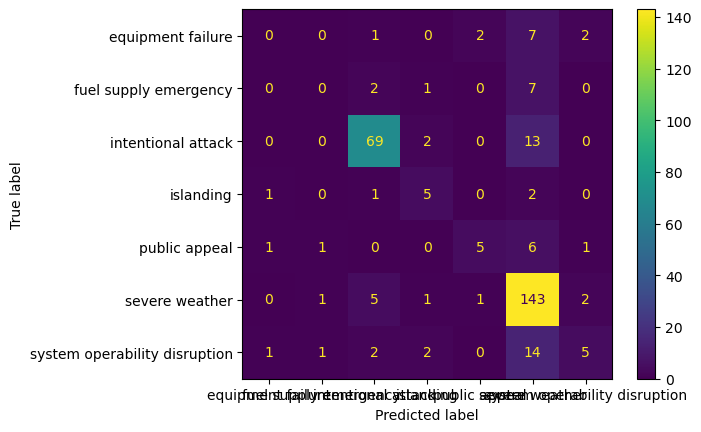

In [217]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.grid(False)

## Step 8: Fairness Analysis

X Group: Areas with Total Customers BELOW the median <br>
Y Group: Areas with Total Customers ABOVE the median

In [227]:
from sklearn.metrics import precision_score


In [224]:
total_customers_median = X_test['TOTAL.CUSTOMERS'].median()

In [225]:
# Create masks for low and high total customer groups
X_group_mask = X_test['TOTAL.CUSTOMERS'] <= total_customers_median
Y_group_mask = X_test['TOTAL.CUSTOMERS'] > total_customers_median

In [229]:
# Compute precision and F1 for X group (low total customers)
X_precision = precision_score(
    y_test[X_group_mask], 
    y_pred[X_group_mask], 
    average='weighted',
    zero_division=0  # Set precision to 0 if no predictions for a class
)
X_f1 = f1_score(
    y_test[X_group_mask], 
    y_pred[X_group_mask], 
    average='weighted',
    zero_division=0  # Set F1 score to 0 if no predictions for a class
)

# Compute precision and F1 for Y group (high total customers)
Y_precision = precision_score(
    y_test[Y_group_mask], 
    y_pred[Y_group_mask], 
    average='weighted',
    zero_division=0
)
Y_f1 = f1_score(
    y_test[Y_group_mask], 
    y_pred[Y_group_mask], 
    average='weighted',
    zero_division=0
)